In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression, RFE, SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from scipy.stats import uniform, randint

In [2]:
df=pd.read_csv('data/train.csv')

**Check basic info on the data set**

In [3]:
df.head()

,date,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,Usage_kWh
0,1/1/2018 0:15,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load,3.17
1,1/1/2018 0:30,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load,4.00
2,1/1/2018 0:45,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load,3.24
3,1/1/2018 1:00,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load,3.31
4,1/1/2018 1:15,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load,3.82


Data Description:

In [4]:
data_shape = df.shape
data_shape

(27999, 11)

In [142]:
num_rows = data_shape[0]
num_columns = data_shape[1]
print("Number of Samples:", num_rows)
print("Number of Features:", num_columns)

Number of Samples: 27999
Number of Features: 11


In [143]:
df.columns

Index(['date', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_of_week', 'Load_Type', 'Usage_kWh'],
      dtype='object')

In [144]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Lagging_Current_Reactive.Power_kVarh,27999.0,13.230912,16.469935,0.00,2.74,5.04,22.82,96.91
Leading_Current_Reactive_Power_kVarh,27880.0,3.881065,7.495718,0.00,0.00,0.00,2.23,27.76
CO2(tCO2),27999.0,0.011790,0.016354,0.00,0.00,0.00,0.02,0.07
Lagging_Current_Power_Factor,27999.0,79.940163,19.397474,36.94,61.64,87.99,99.08,100.00
Leading_Current_Power_Factor,27923.0,84.479796,30.422037,12.50,99.81,100.00,100.00,100.00
NSM,27999.0,42718.611379,24933.404759,0.00,20700.00,42300.00,63900.00,85500.00
Usage_kWh,27999.0,27.888785,33.919271,2.45,3.13,4.57,51.19,153.14


In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27999 entries, 0 to 27998
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  27999 non-null  object 
 1   Lagging_Current_Reactive.Power_kVarh  27999 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  27880 non-null  float64
 3   CO2(tCO2)                             27999 non-null  float64
 4   Lagging_Current_Power_Factor          27999 non-null  float64
 5   Leading_Current_Power_Factor          27923 non-null  float64
 6   NSM                                   27999 non-null  int64  
 7   WeekStatus                            26225 non-null  object 
 8   Day_of_week                           26225 non-null  object 
 9   Load_Type                             27999 non-null  object 
 10  Usage_kWh                             27999 non-null  float64
dtypes: float64(6), 

 **Exploratory Data Analysis (EDA)**



Pairplots using seaborn

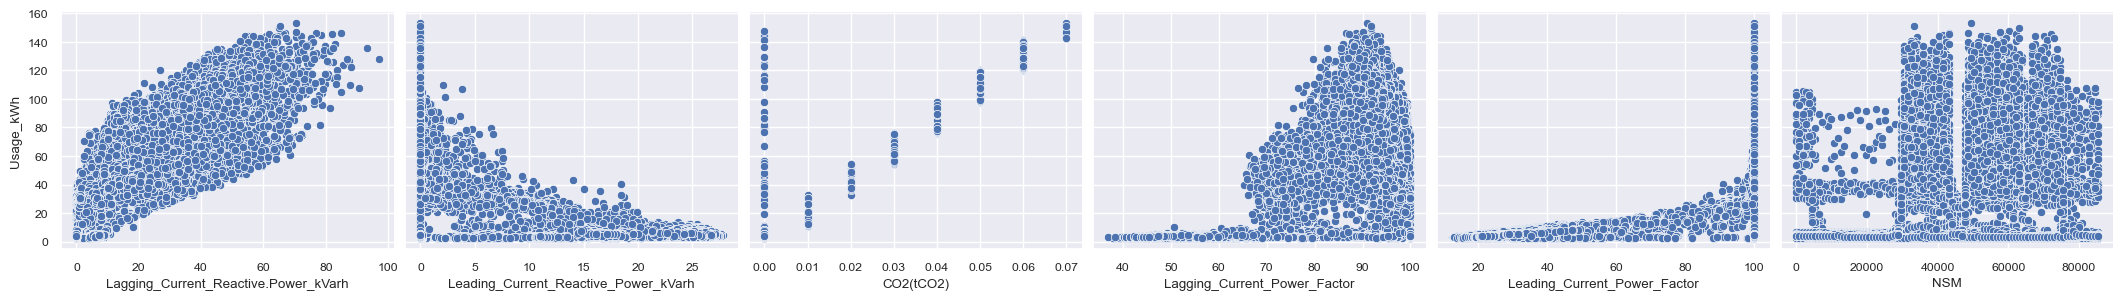

In [87]:
cols = ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
        'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']

sns.pairplot(df, x_vars=cols, y_vars='Usage_kWh', height=3, aspect=1.2, kind='scatter')
plt.show()

Average Usage by Week Status


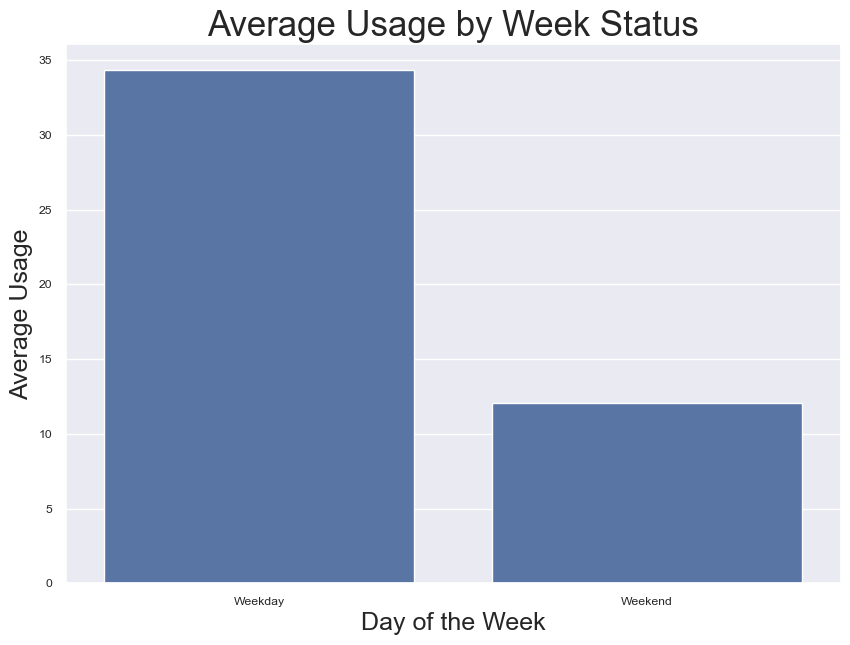

In [88]:
plt.figure(figsize=(10, 7))
sns.barplot(data=df, x="WeekStatus", y="Usage_kWh",errorbar=None)
plt.xlabel("Day of the Week", fontsize=18)
plt.ylabel("Average Usage", fontsize=18)
plt.title("Average Usage by Week Status", fontsize=25)
plt.show()


Average Usage by Day of the Week

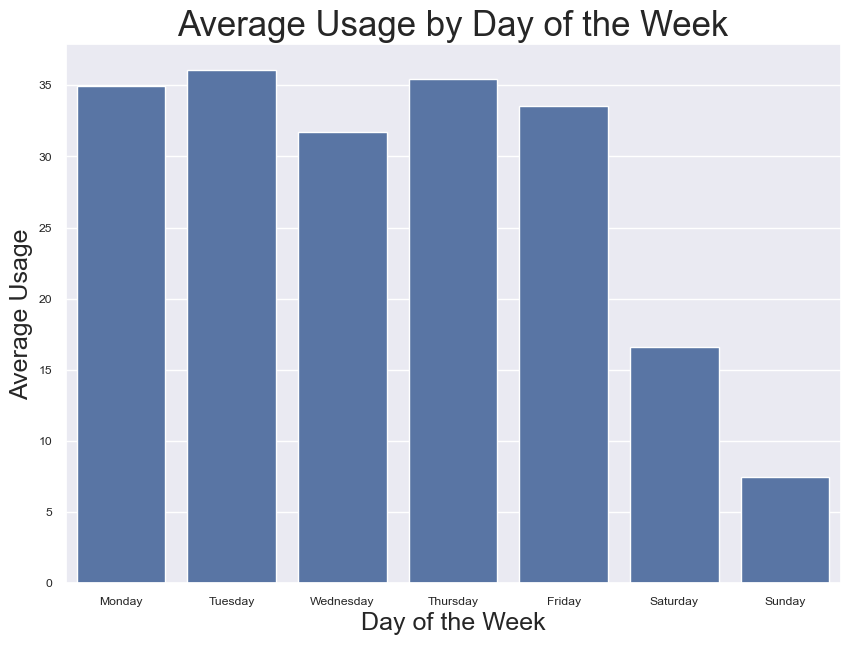

In [89]:
plt.figure(figsize=(10, 7))
sns.barplot(data=df, x="Day_of_week", y="Usage_kWh",errorbar=None)
plt.xlabel("Day of the Week", fontsize=18)
plt.ylabel("Average Usage", fontsize=18)
plt.title("Average Usage by Day of the Week", fontsize=25)
plt.show()


Energy Consumption by Week Status and Load Type


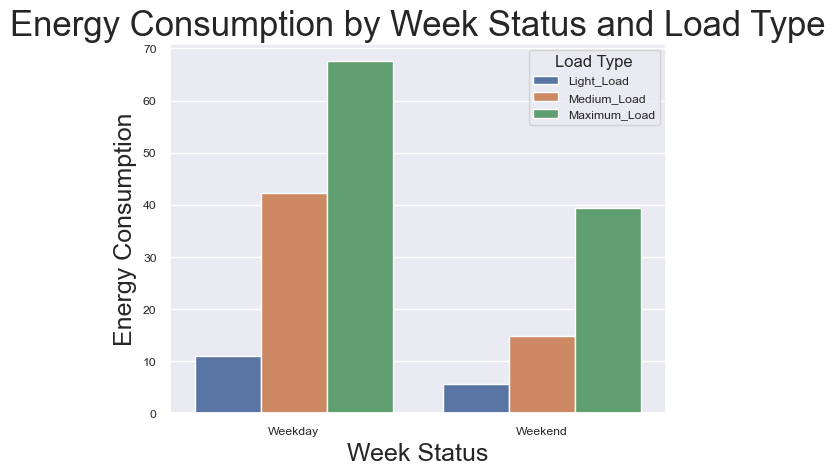

In [90]:
sns.barplot(data=df, x="WeekStatus", y="Usage_kWh", hue="Load_Type",errorbar=None)
plt.xlabel("Week Status", fontsize=18)
plt.ylabel("Energy Consumption", fontsize=18)
plt.title("Energy Consumption by Week Status and Load Type", fontsize=25)
plt.legend(title="Load Type", title_fontsize=12)
plt.show()


Correlation Matrix 

In [5]:
df.set_index('date', inplace=True)

Correlation Heatmap

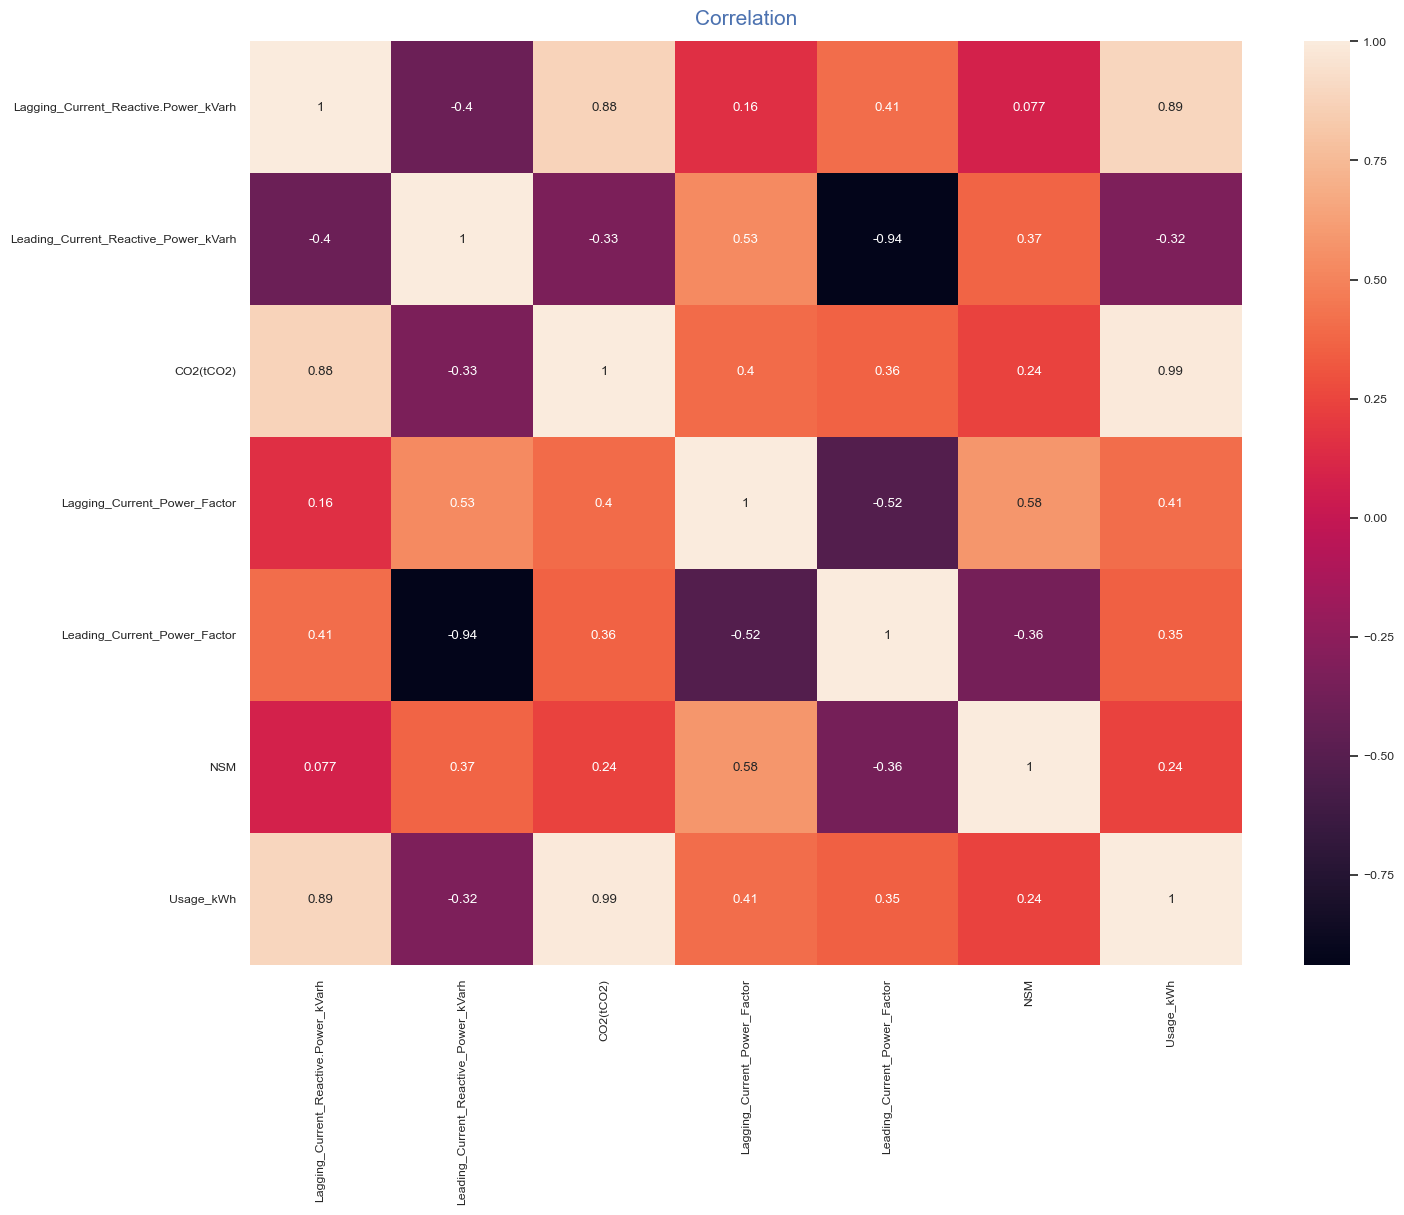

In [6]:
numeric_df = df.select_dtypes(include=['number'])

sns.set(font_scale=0.8)
plt.figure(figsize=(16, 12))
sns.heatmap(numeric_df.corr(), annot=True)
plt.title("Correlation", fontsize=15, color='b', pad=12, loc='center')
plt.show()

**Handling Missing And Categorical data**

In [7]:
missing_vals = df.isnull().sum()
missing_vals

Lagging_Current_Reactive.Power_kVarh       0
Leading_Current_Reactive_Power_kVarh     119
CO2(tCO2)                                  0
Lagging_Current_Power_Factor               0
Leading_Current_Power_Factor              76
NSM                                        0
WeekStatus                              1774
Day_of_week                             1774
Load_Type                                  0
Usage_kWh                                  0
dtype: int64

In [8]:
from sklearn.impute import SimpleImputer

numerical_features = df.select_dtypes(include=['number']).columns
categorical_features = df.select_dtypes(include=['object']).columns

imputer_numerical = SimpleImputer(strategy='mean')
df[numerical_features] = imputer_numerical.fit_transform(df[numerical_features])

imputer_categorical = SimpleImputer(strategy='most_frequent')
df[categorical_features] = imputer_categorical.fit_transform(df[categorical_features])

print("DataFrame after dropping rows with less than 200 missing values and imputing missing values:")
print(df)

df_cleaned = df.copy()

missing_values = df_cleaned.isna().sum()
missing_values

DataFrame after dropping rows with less than 200 missing values and imputing missing values:
                  Lagging_Current_Reactive.Power_kVarh  \
date                                                     
1/1/2018 0:15                                     2.95   
1/1/2018 0:30                                     4.46   
1/1/2018 0:45                                     3.28   
1/1/2018 1:00                                     3.56   
1/1/2018 1:15                                     4.50   
...                                                ...   
19/10/2018 14:45                                 32.62   
19/10/2018 15:00                                 35.46   
19/10/2018 15:15                                 30.92   
19/10/2018 15:30                                 58.18   
19/10/2018 15:45                                 40.46   

                  Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
date                                                                
1/1/2018 0:15 

Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
Usage_kWh                               0
dtype: int64

In [94]:
df.dtypes

Lagging_Current_Reactive.Power_kVarh    float64
Leading_Current_Reactive_Power_kVarh    float64
CO2(tCO2)                               float64
Lagging_Current_Power_Factor            float64
Leading_Current_Power_Factor            float64
NSM                                     float64
WeekStatus                               object
Day_of_week                              object
Load_Type                                object
Usage_kWh                               float64
dtype: object

In [9]:
from datetime import datetime

df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], format="%d/%m/%Y %H:%M")

df_cleaned['day'] = df_cleaned['date'].dt.day

df_cleaned['month'] = df_cleaned['date'].dt.month

df_cleaned['hour_12h'] = df_cleaned['date'].dt.strftime("%I")

df_cleaned.drop(columns=['date'], inplace=True)


KeyError: 'date'

In [41]:
df_cleaned['Reactive_Power_Ratio'] = df_cleaned['Lagging_Current_Reactive.Power_kVarh'] / df_cleaned['Leading_Current_Reactive_Power_kVarh']
df_cleaned['Reactive_Power_Ratio'] = df_cleaned['Reactive_Power_Ratio'].replace(np.inf, np.nan)
df_cleaned['Reactive_Power_Ratio'].fillna(9999, inplace=True)
df_cleaned['Power_Factor_Difference'] = df_cleaned['Lagging_Current_Power_Factor'] - df_cleaned['Leading_Current_Power_Factor']

C:\Users\tbtw0\AppData\Local\Temp\ipykernel_12348\1422213890.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['Reactive_Power_Ratio'].fillna(9999, inplace=True)


In [10]:
df_cleaned.head()

,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,Usage_kWh
date,,,,,,,,,,
1/1/2018 0:15,2.95,0.0,0.0,73.21,100.0,900.0,Weekday,Monday,Light_Load,3.17
1/1/2018 0:30,4.46,0.0,0.0,66.77,100.0,1800.0,Weekday,Monday,Light_Load,4.00
1/1/2018 0:45,3.28,0.0,0.0,70.28,100.0,2700.0,Weekday,Monday,Light_Load,3.24
1/1/2018 1:00,3.56,0.0,0.0,68.09,100.0,3600.0,Weekday,Monday,Light_Load,3.31
1/1/2018 1:15,4.50,0.0,0.0,64.72,100.0,4500.0,Weekday,Monday,Light_Load,3.82


In [11]:
# Perform one-hot encoding on categorical variables
df_cleaned = pd.get_dummies(df_cleaned, columns=["WeekStatus", "Day_of_week", "Load_Type"])

In [12]:
df_cleaned.head()

,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Usage_kWh,WeekStatus_Weekday,WeekStatus_Weekend,Day_of_week_Friday,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Load_Type_Light_Load,Load_Type_Maximum_Load,Load_Type_Medium_Load
date,,,,,,,,,,,,,,,,,,,
1/1/2018 0:15,2.95,0.0,0.0,73.21,100.0,900.0,3.17,True,False,False,True,False,False,False,False,False,True,False,False
1/1/2018 0:30,4.46,0.0,0.0,66.77,100.0,1800.0,4.00,True,False,False,True,False,False,False,False,False,True,False,False
1/1/2018 0:45,3.28,0.0,0.0,70.28,100.0,2700.0,3.24,True,False,False,True,False,False,False,False,False,True,False,False
1/1/2018 1:00,3.56,0.0,0.0,68.09,100.0,3600.0,3.31,True,False,False,True,False,False,False,False,False,True,False,False
1/1/2018 1:15,4.50,0.0,0.0,64.72,100.0,4500.0,3.82,True,False,False,True,False,False,False,False,False,True,False,False


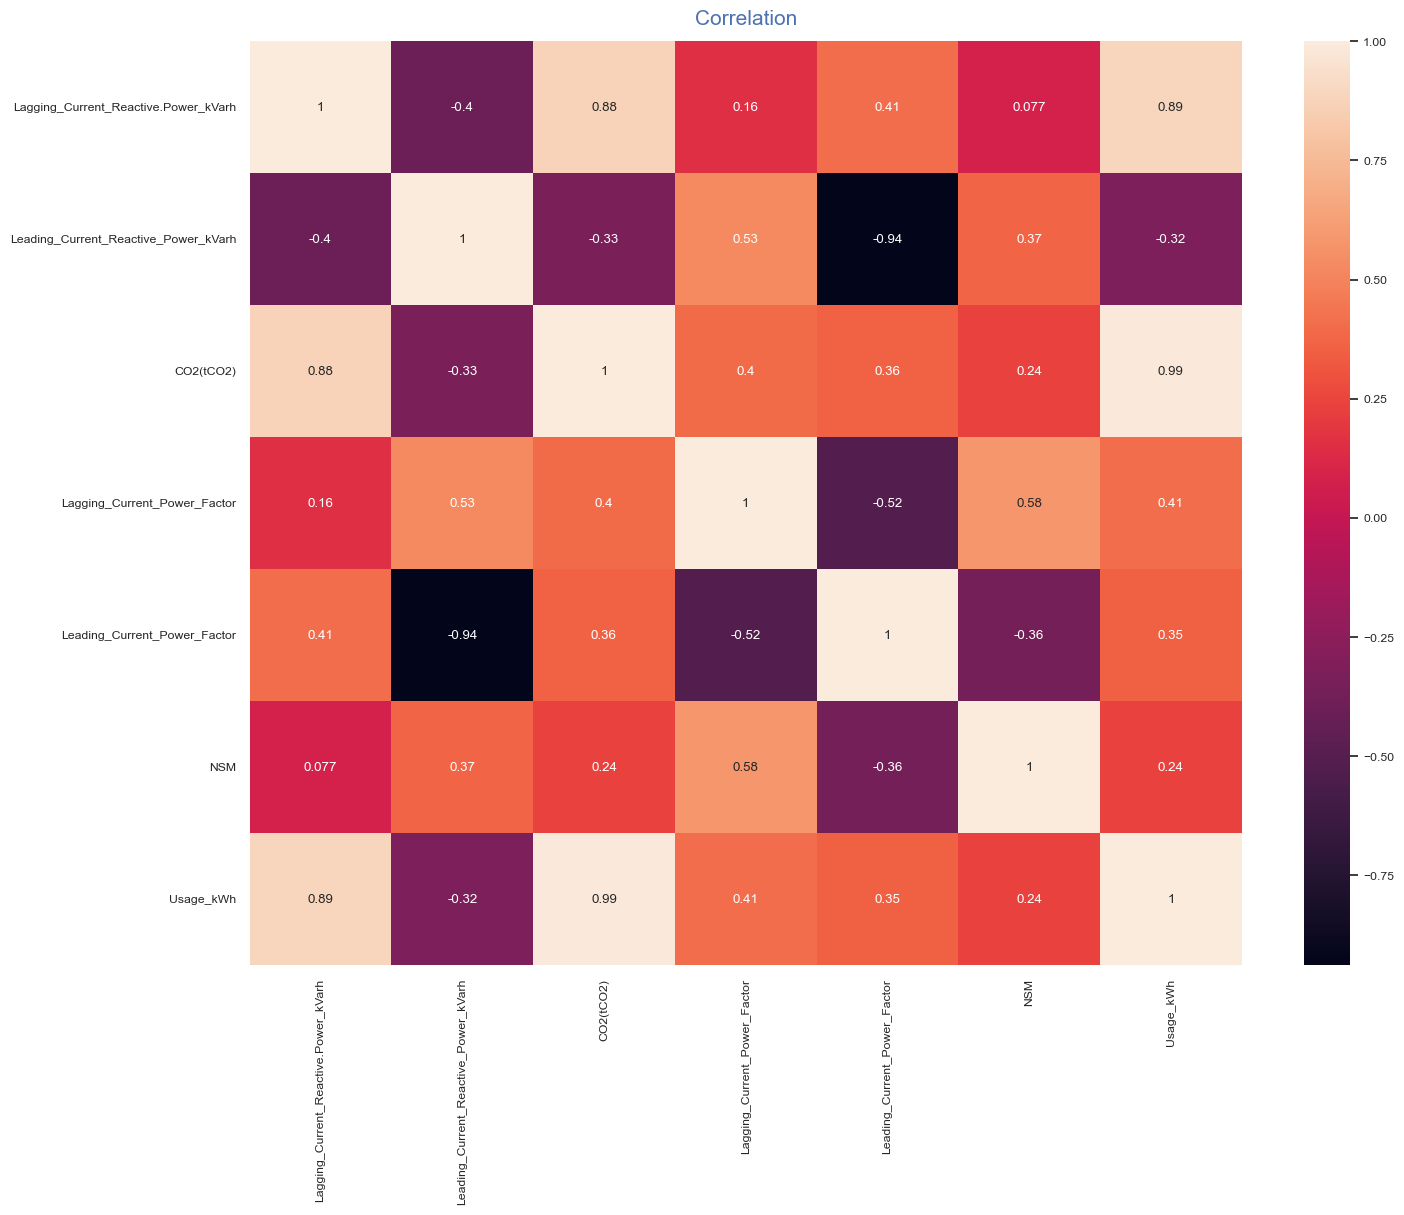

In [98]:
numeric_df = df_cleaned.select_dtypes(include=['number'])

sns.set(font_scale=0.8)
plt.figure(figsize=(16, 12))
sns.heatmap(numeric_df.corr(), annot=True)
plt.title("Correlation", fontsize=15, color='b', pad=12, loc='center')
plt.show()

In [55]:
df_cleaned.to_csv('processed.csv', index=False)

**Data Preprocessing**

 Splitting the DataFrame






In [13]:
X = df_cleaned.drop(['Usage_kWh'], axis=1)
y=df_cleaned.Usage_kWh

*Feature Selection*


In [14]:
y_ = y.astype('int')

select_reg = SelectKBest(k=7, score_func=f_regression).fit(X, y_)
X_select = select_reg.transform(X)

In [15]:
Selected_features = pd.DataFrame({'columns': X.columns, 'Kept': select_reg.get_support()})
Selected_features

,columns,Kept
0,Lagging_Current_Reactive.Power_kVarh,True
1,Leading_Current_Reactive_Power_kVarh,True
2,CO2(tCO2),True
3,Lagging_Current_Power_Factor,True
4,Leading_Current_Power_Factor,True
5,NSM,False
6,WeekStatus_Weekday,False
7,WeekStatus_Weekend,False
8,Day_of_week_Friday,False
9,Day_of_week_Monday,False


Other Feature Selectors

In [200]:
rf_selector = RandomForestRegressor(n_estimators=100)
rf_selector.fit(X, y)
importances = rf_selector.feature_importances_
selected_features_rf = df_cleaned.columns[np.argsort(importances)[::-1][:5]]

In [203]:
selected_features_rf
X_select = df_cleaned[selected_features_rf]

In [229]:
linear_reg = LinearRegression()

rfe_selector = RFE(estimator=linear_reg, n_features_to_select=5)

rfe_selector.fit(X, y)

selected_features_rfe = X.columns[rfe_selector.support_]

print("Selected features using RFE:", selected_features_rfe)

Selected features using RFE: Index(['CO2(tCO2)', 'Day_of_week_Tuesday', 'Load_Type_Light_Load',
       'Load_Type_Maximum_Load', 'Load_Type_Medium_Load'],
      dtype='object')


 Standardizing the Features

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X_select)

# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

# X = scaler.fit_transform(X_select)

Test-train split

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Training Set - X_train shape:", X_train.shape)
print("Training Set - y_train shape:", y_train.shape)
print("Testing Set - X_test shape:", X_test.shape)
print("Testing Set - y_test shape:", y_test.shape)
print("Validation Set - X_val shape:", X_val.shape)
print("Validation Set - y_val shape:", y_val.shape)

Training Set - X_train shape: (15679, 7)
Training Set - y_train shape: (15679,)
Testing Set - X_test shape: (8400, 7)
Testing Set - y_test shape: (8400,)
Validation Set - X_val shape: (3920, 7)
Validation Set - y_val shape: (3920,)


**Linear Regression Model**

In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

linear_reg = LinearRegression()

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

y_pred_train_cv = cross_val_predict(linear_reg, X_train, y_train, cv=kfold)

linear_reg.fit(X_train, y_train)

y_pred_val = linear_reg.predict(X_val)

y_pred_test = linear_reg.predict(X_test)


Model Evaluation

In [19]:
mse_train_cv = mean_squared_error(y_train, y_pred_train_cv)
r2_train_cv = r2_score(y_train, y_pred_train_cv)
print("Cross-Validation Training Performance:")
print('Mean Squared Error:', mse_train_cv)
print('R^2 Score:', r2_train_cv)

mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)
print("\nValidation Performance:")
print('Mean Squared Error:', mse_val)
print('R^2 Score:', r2_val)

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print("\nTesting Performance:")
print('Mean Squared Error:', mse_test)
print('R^2 Score:', r2_test)

Cross-Validation Training Performance:
Mean Squared Error: 27.42714602720277
R^2 Score: 0.9763730721231549

Validation Performance:
Mean Squared Error: 23.930481417886284
R^2 Score: 0.978333262383276

Testing Performance:
Mean Squared Error: 19.268800606091375
R^2 Score: 0.9832700251205103


Loss Function Plot (Learning Curve)

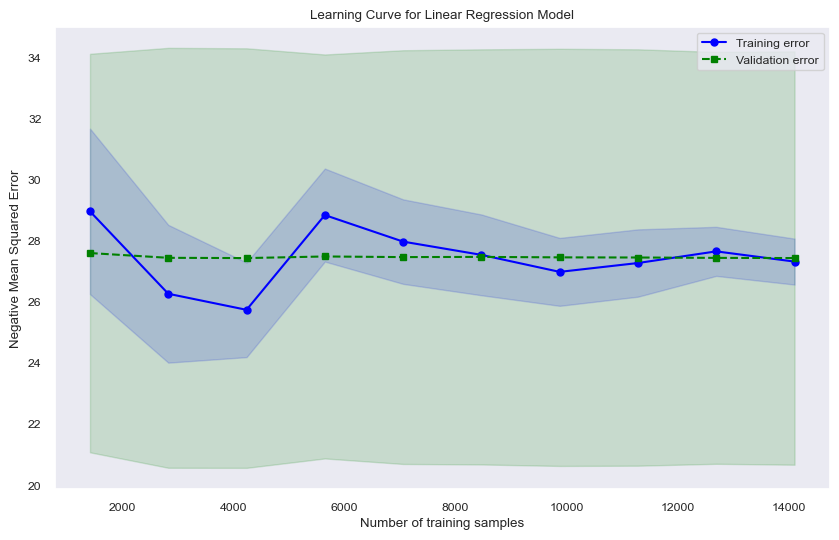

In [20]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=linear_reg,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=kfold,
    scoring='neg_mean_squared_error'
)

train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training error')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation error')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Negative Mean Squared Error')
plt.legend(loc='upper right')
plt.title('Learning Curve for Linear Regression Model')
plt.show()

**Polynomial Regression Model**

In [21]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('linear_reg', LinearRegression())
])

param_grid = {
    'poly__degree': [2, 3, 4, 5]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)

grid_search.fit(X_train, y_train)

best_degree = grid_search.best_params_['poly__degree']

y_pred_val = grid_search.predict(X_val)
y_pred_test = grid_search.predict(X_test)

mse_val = mean_squared_error(y_val, y_pred_val)
mse_test = mean_squared_error(y_test, y_pred_test)

print("Best degree:", best_degree)
print("Mean Squared Error (Validation):", mse_val)
print("Mean Squared Error (Test):", mse_test)

Best degree: 3
Mean Squared Error (Validation): 6.167126680247349
Mean Squared Error (Test): 2.3307856576253156


Model Evaluation

In [22]:
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Hyperparameters:")
print("Polynomial Degree:", best_degree)
print('Mean Squared Error (Validation):', mse_val)
print('R-squared Score (Validation):', r2_val)

print('Mean Squared Error (Testing):', mse_test)
print('R-squared Score (Testing):', r2_test)

Hyperparameters:
Polynomial Degree: 3
Mean Squared Error (Validation): 6.167126680247349
R-squared Score (Validation): 0.994416262953651
Mean Squared Error (Testing): 2.3307856576253156
R-squared Score (Testing): 0.9979763148574375


Loss Function Plot (Learning Curve)

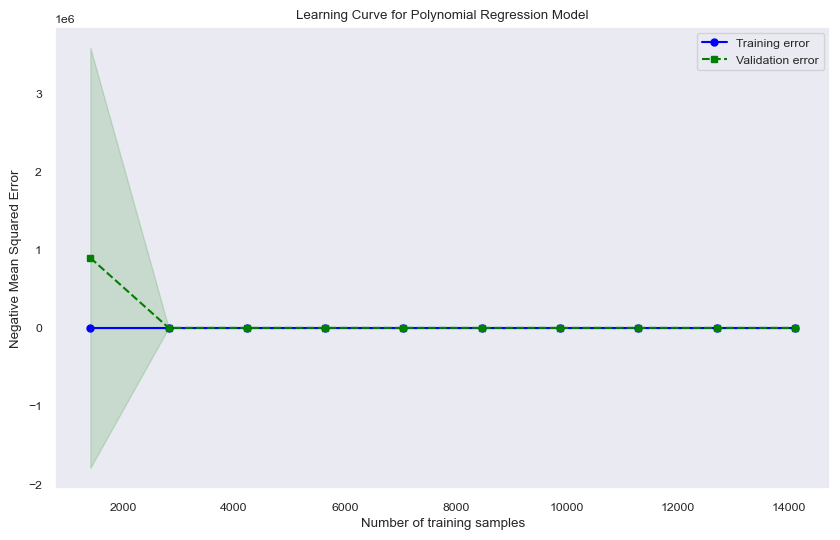

In [23]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=grid_search.best_estimator_,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=kfold,
    scoring='neg_mean_squared_error'
)

train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training error')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation error')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Negative Mean Squared Error')
plt.legend(loc='upper right')
plt.title('Learning Curve for Polynomial Regression Model')
plt.show()

**Lasso Regression Model** 

In [48]:
degree = 2
poly = PolynomialFeatures(degree)

lasso_poly = make_pipeline(poly, Lasso(max_iter=10000))

param_grid = {
    'polynomialfeatures__degree': [2],
    'lasso__alpha': [0.1, 1, 0.5, 5 , 3, 10]
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=lasso_poly, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_model_lasso = grid_search.best_estimator_

y_pred_test = best_model_lasso.predict(X_test)

y_pred_val = best_model_lasso.predict(X_val)


In [49]:
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Test set evaluation:")
print("Best hyperparameters:", grid_search.best_params_)
print('Mean Squared Error (Test):', mse_test)
print('R-squared Score (Test):', r2_test)

mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print("\nValidation set evaluation:")
print("Mean Squared Error (Validation):", mse_val)
print('R-squared Score (Validation):', r2_val)

Test set evaluation:
Best hyperparameters: {'lasso__alpha': 0.1, 'polynomialfeatures__degree': 2}
Mean Squared Error (Test): 6.367490387417127
R-squared Score (Test): 0.9944714797560776

Validation set evaluation:
Mean Squared Error (Validation): 5.816624961027219
R-squared Score (Validation): 0.9947336083781722


Loss Function Plot (Learning Curve)

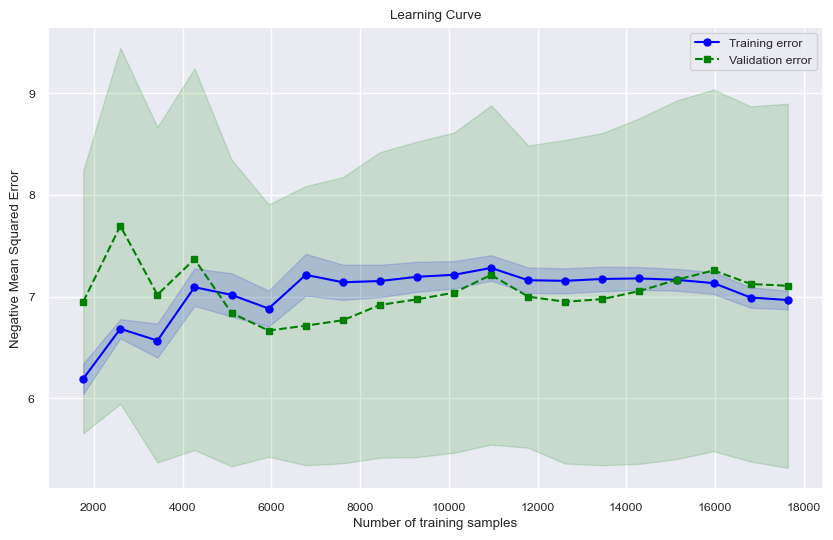

In [50]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

larger_train_sizes = np.linspace(0.1, 1.0, 20)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model_lasso,
    X=np.concatenate((X_train, X_val)),
    y=np.concatenate((y_train, y_val)),
    train_sizes=larger_train_sizes,
    cv=kf,
    scoring='neg_mean_squared_error'
)

train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training error')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation error')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.xlabel('Number of training samples')
plt.ylabel('Negative Mean Squared Error')
plt.legend(loc='upper right')
plt.title('Learning Curve')

plt.show()


Other Models Evaluations

In [93]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

random_forest = RandomForestRegressor()
param_grid_rf = {'n_estimators': [50, 100, 200]}
kf = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search_rf = GridSearchCV(estimator=random_forest, param_grid=param_grid_rf, cv=kf, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)
best_model_rf = grid_search_rf.best_estimator_

y_pred_rf = best_model_rf.predict(X_test)

xgb_model = XGBRegressor()
param_grid_xgb = {'n_estimators': [50, 100, 200], 'learning_rate': [0.05, 0.1, 0.2]}
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=kf, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train, y_train)
best_model_xgb = grid_search_xgb.best_estimator_

y_pred_xgb = best_model_xgb.predict(X_test)

y_pred_stacked = np.mean([y_pred_rf, y_pred_xgb], axis=0)

mse_stacked = mean_squared_error(y_test, y_pred_stacked)
r2_stacked = r2_score(y_test, y_pred_stacked)

print("Stacked Model Metrics:")
print('Mean Squared Error (Stacked Model):', mse_stacked)
print('R-squared Score (Stacked Model):', r2_stacked)


Stacked Model Metrics:
Mean Squared Error (Stacked Model): 0.9369472457534779
R-squared Score (Stacked Model): 0.9991865033945129


In [65]:
ylasso_pred=best_model_rf.predict(X_test)

In [66]:
lasso_model=pd.DataFrame({'Actual Value':y_test,'Predicted Value':ylasso_pred,'Difference':y_test-ylasso_pred})
lasso_model[0:5]

,Actual Value,Predicted Value,Difference
date,,,
17/08/2018 17:30,40.28,40.5134,-2.334000e-01
22/02/2018 10:45,89.10,88.5654,5.346000e-01
11/8/2018 0:30,2.81,2.8100,-1.776357e-15
28/08/2018 09:00,45.90,48.1055,-2.205500e+00
15/07/2018 05:45,2.81,2.8100,-1.776357e-15


**Support Vector Regression Model**

In [21]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X, y)

SVR()

In [22]:
yregressor_pred = regressor.predict(X_test)
regressor_model=pd.DataFrame({'Actual Value':y_test,'Predicted Value':yregressor_pred,'Difference':y_test-yregressor_pred})
regressor_model[0:5]

,Actual Value,Predicted Value,Difference
date,,,
12/8/2018 5:30,2.74,2.801148,-0.061148
19/09/2018 08:00,4.90,4.867736,0.032264
17/06/2018 02:00,2.81,2.821500,-0.011500
13/06/2018 16:00,3.60,5.037221,-1.437221
26/08/2018 20:45,3.10,3.184966,-0.084966


In [23]:
print('Support Vector Regression Model')
mean_squared_error=metrics.mean_squared_error(y_test,yregressor_pred)
print('Sqaured mean error', round(np.sqrt(mean_squared_error),2))
print('R squared training',round(regressor.score(X_train,y_train),4))
print('R sqaured testing',round(regressor.score(X_test,y_test),4) )

Support Vector Regression Model
Sqaured mean error 2.64
R squared training 0.9932
R sqaured testing 0.9938


**Testing Data**

In [26]:
testing_data = pd.read_csv('data/test.csv')
testing_data = testing_data.set_index('date')
testing_data = testing_data.drop(['Id', 'Day_of_week','NSM'], axis=1)

In [27]:
numerical_cols_test = testing_data.select_dtypes(include=[np.number]).columns.tolist()

numerical_cols_test = [col for col in numerical_cols_test if col not in ['date']]

scaler_test = StandardScaler()

testing_data[numerical_cols_test] = scaler_test.fit_transform(testing_data[numerical_cols_test])

In [28]:
numerical_cols_test

['Lagging_Current_Reactive.Power_kVarh',
 'Leading_Current_Reactive_Power_kVarh',
 'CO2(tCO2)',
 'Lagging_Current_Power_Factor',
 'Leading_Current_Power_Factor']

In [29]:
testing_data = pd.get_dummies(testing_data)

In [30]:
testing_data

,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,WeekStatus_Weekday,WeekStatus_Weekend,Load_Type_Light_Load,Load_Type_Maximum_Load,Load_Type_Medium_Load
date,,,,,,,,,,
19/10/2018 16:00,3.293564,-0.542462,2.588771,0.064562,0.529035,True,False,False,True,False
19/10/2018 16:15,2.685094,-0.542462,1.933952,0.130005,0.529035,True,False,False,True,False
19/10/2018 16:30,2.740176,-0.542462,1.933952,0.130005,0.529035,True,False,False,True,False
19/10/2018 16:45,1.546293,-0.542462,1.279133,0.060959,0.529035,True,False,False,True,False
19/10/2018 17:00,1.467512,-0.542462,1.279133,0.117997,0.529035,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...
31/12/2018 23:00,-0.473829,-0.542462,-0.685323,-1.261712,0.529035,True,False,True,False,False
31/12/2018 23:15,-0.545564,-0.542462,-0.685323,-0.744772,0.529035,True,False,True,False,False
31/12/2018 23:30,-0.582073,-0.532716,-0.685323,-0.389938,0.528384,True,False,True,False,False


In [31]:
testing_data = testing_data.drop(['Load_Type_Medium_Load','WeekStatus_Weekend','WeekStatus_Weekday'], axis=1)

In [32]:
testing_data

,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,Load_Type_Light_Load,Load_Type_Maximum_Load
date,,,,,,,
19/10/2018 16:00,3.293564,-0.542462,2.588771,0.064562,0.529035,False,True
19/10/2018 16:15,2.685094,-0.542462,1.933952,0.130005,0.529035,False,True
19/10/2018 16:30,2.740176,-0.542462,1.933952,0.130005,0.529035,False,True
19/10/2018 16:45,1.546293,-0.542462,1.279133,0.060959,0.529035,False,True
19/10/2018 17:00,1.467512,-0.542462,1.279133,0.117997,0.529035,False,True
...,...,...,...,...,...,...,...
31/12/2018 23:00,-0.473829,-0.542462,-0.685323,-1.261712,0.529035,True,False
31/12/2018 23:15,-0.545564,-0.542462,-0.685323,-0.744772,0.529035,True,False
31/12/2018 23:30,-0.582073,-0.532716,-0.685323,-0.389938,0.528384,True,False


In [33]:
# y_test_pred_stacked_rf = best_model_rf.predict(testing_data)
# y_test_pred_stacked_knn = best_model_xgb.predict(testing_data)

# X_test_stacked = np.column_stack((y_test_pred_stacked_rf, y_test_pred_stacked_knn))

# y_test_pred_final = np.mean(X_test_stacked, axis=1)

y_test_pred = best_model_lasso.predict(testing_data)

c:\Users\tbtw0\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


In [35]:
testing = testing_data.copy()

testing['Usage_kWh'] = y_test_pred
testing.to_csv('test_pred.csv', index=False)